# Bella&Bona: Take-Home Project (Data Analyst)

## Imports

- `sqlite3`: Used for connecting to the SQLite database.
- `pandas as pd`: Used for data manipulation and analysis.
- `numpy as np`: Used for numerical operations.
- `matplotlib.pyplot as plt`: Used for plotting graphs.
- `seaborn as sns`: Used for statistical data visualization.
- `train_test_split` from `sklearn.model_selection`: Used for splitting data into training and testing sets.
- `LinearRegression` from `sklearn.linear_model`: Used for linear regression modeling.
- `mean_squared_error`, `mean_absolute_error`, `r2_score` from `sklearn.metrics`: Used for evaluating model performance.
- `cross_val_score` from `sklearn.model_selection`: Used for cross-validation.
- `SARIMAX` from `statsmodels.tsa.statespace.sarimax`: Used for SARIMA modeling.
- `ARIMA` from `statsmodels.tsa.arima.model`: Used for ARIMA modeling.
- `datetime`, `timedelta` from `datetime`: Used for date and time manipulation.
- `adfuller` from `statsmodels.tsa.stattools`: Used for the Augmented Dickey-Fuller test.
- `itertools`: Used for creating iterators for efficient looping.
- `warnings`: Used for managing warnings.

In [36]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import itertools
import warnings
warnings.filterwarnings("ignore")


```markdown
## Data Sources

- `datasets/dishes_csv.csv`: Contains information about the dishes.
- `datasets/users_csv.csv`: Contains information about the users.
- `datasets/orders_csv.csv`: Contains information about the orders.
- `db/bellabona.db`: SQLite database file containing the data.
```

In [37]:
dishes = "datasets/dishes_csv.csv"
users = 'datasets/users_csv.csv'
orders = 'datasets/orders_csv.csv'

db_file = 'db/bellabona.db'

In [38]:
data_dishes = pd.read_csv(dishes, delimiter=',')
data_users = pd.read_csv(users, delimiter=',')
data_orders = pd.read_csv(orders, delimiter=';')
data_orders.columns = ['id', 'user_id', 'dish_id', 'date']

In the file `db/bellasql.py`, we create a database named `bellabona.db` and convert the CSV files to tables in the database using the following command:

```python
data_dishes.to_sql('dishes', conn, if_exists='append', index=False)
```


## **Part 1: SQL**

In [39]:
conn = sqlite3.connect(db_file)
cursor = conn.cursor()


### SQL Query 1 Explanation

The following SQL query calculates the activation rate of users for the months of July, August, and September 2024. The activation rate is defined as the ratio of users who placed an order in a given month to the total number of users.

### Query Breakdown

1. **Common Table Expression (CTE): `total_users`**
    - This CTE calculates the total number of distinct users from the `users` table.

2. **Main Query**
    - The main query consists of three `SELECT` statements combined using `UNION ALL` to get the activation rate for July, August, and September 2024.
    - Each `SELECT` statement:
      - Assigns the respective month name.
      - Counts the number of distinct users who placed an order in the specified month.
      - Retrieves the total user count from the `total_users` CTE.
      - Calculates the activation rate as the ratio of users with orders to the total number of users.



### Python Code
The following Python code executes the SQL query and stores the results in a pandas DataFrame for further analysis.

```python
cursor.execute(query)
results = cursor.fetchall()

columns = ['month', 'users_with_order', 'Total_Users', 'activation_rate']

```


In [40]:
query = '''
WITH total_users AS (
  SELECT COUNT(DISTINCT id) AS total_user_count
  FROM users
)
SELECT 
  'July' AS month, 
  COUNT(DISTINCT o.user_id) AS users_with_order, 
  tu.total_user_count AS Total_Users,
  (COUNT(DISTINCT o.user_id) * 1.0 / tu.total_user_count) AS activation_rate
FROM orders o, total_users tu
WHERE o.date >= '2024-07-01T00:00:00Z' 
  AND o.date < '2024-08-01T00:00:00Z'
GROUP BY month

UNION ALL

SELECT 
  'August' AS month, 
  COUNT(DISTINCT o.user_id) AS users_with_order, 
  tu.total_user_count AS Total_Users,
  (COUNT(DISTINCT o.user_id) * 1.0 / tu.total_user_count) AS activation_rate
FROM orders o, total_users tu
WHERE o.date >= '2024-08-01T00:00:00Z' 
  AND o.date < '2024-09-01T00:00:00Z'
GROUP BY month

UNION ALL

SELECT 
  'September' AS month, 
  COUNT(DISTINCT o.user_id) AS users_with_order, 
  tu.total_user_count AS Total_Users,
  (COUNT(DISTINCT o.user_id) * 1.0 / tu.total_user_count) AS activation_rate
FROM orders o, total_users tu
WHERE o.date >= '2024-09-01T00:00:00Z' 
  AND o.date < '2024-10-01T00:00:00Z'
GROUP BY month;
'''

cursor.execute(query)
results = cursor.fetchall()

columns = ['month', 'users_with_order', 'Total_Users', 'activation_rate']
activation_rate = pd.DataFrame(results, columns=columns)

print(activation_rate)

       month  users_with_order  Total_Users  activation_rate
0       July                53          100             0.53
1     August                55          100             0.55
2  September                51          100             0.51


### SQL Query 2 Explanation

Here we rank dish categories by the number of orders in different cities. 
1. **Common Table Expressions (CTEs)**:
    - **`category_order_count`**: This CTE calculates the number of orders (`order_count`) for each dish category in each city by joining the `orders`, `dishes`, and `users` tables.
    - **`ranked_categories`**: This CTE ranks the dish categories within each city based on the `order_count` in descending order using the `RANK()` window function.

2. **Main Query**:
    - The main query selects the city, category, and order count from the `ranked_categories` CTE where the category rank is within the top 3 for each city. The results are ordered by city and category rank.


In [41]:
query2 = '''
WITH category_order_count AS (
    SELECT 
        u.city,
        d.category,
        COUNT(o.id) AS order_count
    FROM 
        orders o
    JOIN 
        dishes d ON o.dish_id = d.id
    JOIN 
        users u ON o.user_id = u.id
    GROUP BY 
        u.city, d.category
),
ranked_categories AS (
    SELECT 
        city,
        category,
        order_count,
        RANK() OVER (PARTITION BY city ORDER BY order_count DESC) AS category_rank
    FROM 
        category_order_count
)
SELECT 
    city,
    category,
    order_count
FROM 
    ranked_categories
WHERE 
    category_rank <= 3
ORDER BY 
    city, category_rank;
'''

cursor.execute(query2)
results = cursor.fetchall()

columns = ['city', 'category', 'order_count']
order_count = pd.DataFrame(results, columns=columns)

print(order_count)

      city                                       category  order_count
0   Berlin  Cuisine Type (e.g. Italian, Mexican, Chinese)           69
1   Berlin                                      Side Dish           42
2   Berlin                                          Vegan           42
3  Hamburg  Cuisine Type (e.g. Italian, Mexican, Chinese)           57
4  Hamburg                                    Main Course           33
5  Hamburg                                     Vegetarian           33
6   Munich  Cuisine Type (e.g. Italian, Mexican, Chinese)           84
7   Munich                                    Gluten-Free           43
8   Munich                                    Main Course           41


### SQL Query 3 Explanation

We calculate the total revenue generated from orders for each month and year. The revenue is aggregated by summing the prices of the dishes ordered in each month.

1. **Date Formatting**:
    - The `strftime` function is used to extract the month number, month name, and year from the order date.

2. **Revenue Calculation**:
    - The `SUM` function is used to calculate the total revenue for each month by summing the prices of the dishes ordered.

3. **Grouping and Ordering**:
    - The results are grouped by year and month number to get the total revenue for each month.
    - The results are ordered by year and month number to ensure chronological order.

In [42]:
query3 = '''
SELECT  
    strftime('%m', o.date) AS month_number,
    CASE strftime('%m', o.date)
        WHEN '01' THEN 'January'
        WHEN '02' THEN 'February'
        WHEN '03' THEN 'March'
        WHEN '04' THEN 'April'
        WHEN '05' THEN 'May'
        WHEN '06' THEN 'June'
        WHEN '07' THEN 'July'
        WHEN '08' THEN 'August'
        WHEN '09' THEN 'September'
        WHEN '10' THEN 'October'
        WHEN '11' THEN 'November'
        WHEN '12' THEN 'December'
    END AS month_name,
    strftime('%Y', o.date) AS year,
    SUM(d.price) AS total_revenue
FROM 
    orders o
JOIN 
    dishes d ON o.dish_id = d.id
GROUP BY 
    year, month_number  
ORDER BY 
    year, month_number;
'''

cursor.execute(query3)
results = cursor.fetchall()

columns = [ 'month_number', 'month_name', 'year', 'total_revenue']
total_revenue = pd.DataFrame(results, columns=columns)

# Display the DataFrame
print(total_revenue)

  month_number month_name  year  total_revenue
0           05        May  2024        1263.78
1           06       June  2024        1436.56
2           07       July  2024        1220.65
3           08     August  2024        1404.01
4           09  September  2024        1389.89
5           10    October  2024        1358.74


In [43]:
data_dishes.head()

,id,name,category,price
0,493fa57d-3850-8773-442c-2b7afad83933,Caesar Salad,Side Dish,7.61
1,bae94eab-79e9-7e69-0699-f7b7263ff8b0,Beef Stroganoff,Dessert,5.60
2,eb62fde4-4f43-c7f6-d323-0d0e4131ac17,Shrimp Pad Thai,Vegetarian,7.30
3,5d0378fb-45ae-f69a-0c59-80668c414007,Quiche Lorraine,"Cuisine Type (e.g. Italian, Mexican, Chinese)",9.53
4,b5843967-cf48-5bf0-a5c9-170a1933e7a8,Fish Tacos,Main Course,11.71


In [44]:
data_users.head()

,id,diet,city
0,0855242f-46f0-d2c1-d5f0-ac35b4074270,Meat,Hamburg
1,98763f8b-14bd-7f09-36f7-df022691e120,Vegetarian,Berlin
2,96d800fc-2bb0-f19e-9bdd-049e0158e2c4,Gluten-free,Munich
3,c1d9fd42-fbca-e2a7-b080-37a51077fa06,Meat,Munich
4,24280a8d-9972-c7e5-9adf-164cfcdbbdd7,Vegetarian,Hamburg


In [45]:
data_orders.head()

,id,user_id,dish_id,date
0,2fe611a7-f73b-4e72-be34-48dfbcfd441d,c201c515-42f8-f321-69df-c1c24354b9f8,cc6adc74-fe56-840c-9cd0-015948f2e774,2024-05-01T00:04:34Z
1,5d98d225-78bd-4a59-a291-c37671dd32c2,08523b6f-95c3-4e80-624b-6cdb25645aa0,b5843967-cf48-5bf0-a5c9-170a1933e7a8,2024-05-01T21:45:03Z
2,9e23cf11-63b2-4bc1-aa48-cec1b31cd29e,951c74b0-55b6-dcce-b081-e9674b38b7b7,0eca4f84-43ab-656e-d14b-1fbd6acc525f,2024-05-01T22:13:14Z
3,f97eb0cb-9ecb-4495-99e7-6dae982e983b,d4c44f9a-cb3a-8c25-516e-91f463ba6988,eb62fde4-4f43-c7f6-d323-0d0e4131ac17,2024-05-02T01:04:56Z
4,851f6e4b-5dc3-436c-ad4d-41467c624d37,34cc30a6-1698-e38a-73cb-8acf8901f11c,493fa57d-3850-8773-442c-2b7afad83933,2024-05-02T05:45:23Z


## **Part 2: Data Analysis**

### Merging DataFrames and Cleaning Data

#### Foreign Key Relationships

The `id` columns in the `dishes` and `users` tables can be used as foreign keys to merge these tables with the `orders` table. Specifically, the `id` in `dishes` can be linked to the `dish_id` in `orders`, and the `id` in `users` can be linked to the `user_id` in `orders`. This allows us to combine data from these tables based on the relationships defined by these keys.

In [46]:
merged_df = pd.merge(data_orders, data_users, left_on='user_id', right_on='id', how='inner')

combined_data = pd.merge(merged_df, data_dishes, left_on='dish_id', right_on='id', how='inner')

combined_data = combined_data.drop(columns=['user_id', 'dish_id', 'id_x', 'id_y'])

combined_data.head()

,date,diet,city,id,name,category,price
0,2024-05-01T00:04:34Z,Vegan,Munich,cc6adc74-fe56-840c-9cd0-015948f2e774,Baked Ziti,"Cuisine Type (e.g. Italian, Mexican, Chinese)",4.23
1,2024-05-01T21:45:03Z,Gluten-free,Hamburg,b5843967-cf48-5bf0-a5c9-170a1933e7a8,Fish Tacos,Main Course,11.71
2,2024-05-01T22:13:14Z,Meat,Hamburg,0eca4f84-43ab-656e-d14b-1fbd6acc525f,Grilled Salmon,Gluten-Free,11.51
3,2024-05-02T01:04:56Z,Vegan,Munich,eb62fde4-4f43-c7f6-d323-0d0e4131ac17,Shrimp Pad Thai,Vegetarian,7.30
4,2024-05-02T05:45:23Z,Vegetarian,Munich,493fa57d-3850-8773-442c-2b7afad83933,Caesar Salad,Side Dish,7.61


### Visualization of Order Distributions

In this analysis, we aim to understand how orders are distributed across different factors such as diet categories, cities, and dates. By visualizing the data, we can identify trends and patterns.

- **Diet Categories**: We examine how various types of diets (e.g., vegetarian, vegan, gluten-free) impact the order frequency and distribution.
- **Cities**: The geographic distribution of orders is analyzed to understand regional preferences and identify potential areas for expansion or focus.
- **Date**: We explore how orders are placed over time, looking for seasonal trends, daily variations, or any patterns.

#### Distribution of Orders based on Diet Categories and Cities

##### Distribution of Diet Categories
 
Vegetarian appears to be the most common, with over 400 instances, followed by gluten-free around 200, meat-based around 150, and vegan around 100.
The large gap between vegetarian and the other categories suggests vegetarian diets are significantly more common in this data set.
This could indicate vegetarian diets are more widely adopted or preferred compared to the other dietary choices shown.

##### Distribution of Cities

Munich has by far the highest count, with over 300 data points.Hamburg has the second highest count, around 175.Berlin has the lowest count, around 100.The large difference in counts between the cities suggests Munich may have a much larger sample size or population represented in the data compared to Hamburg and Berlin.

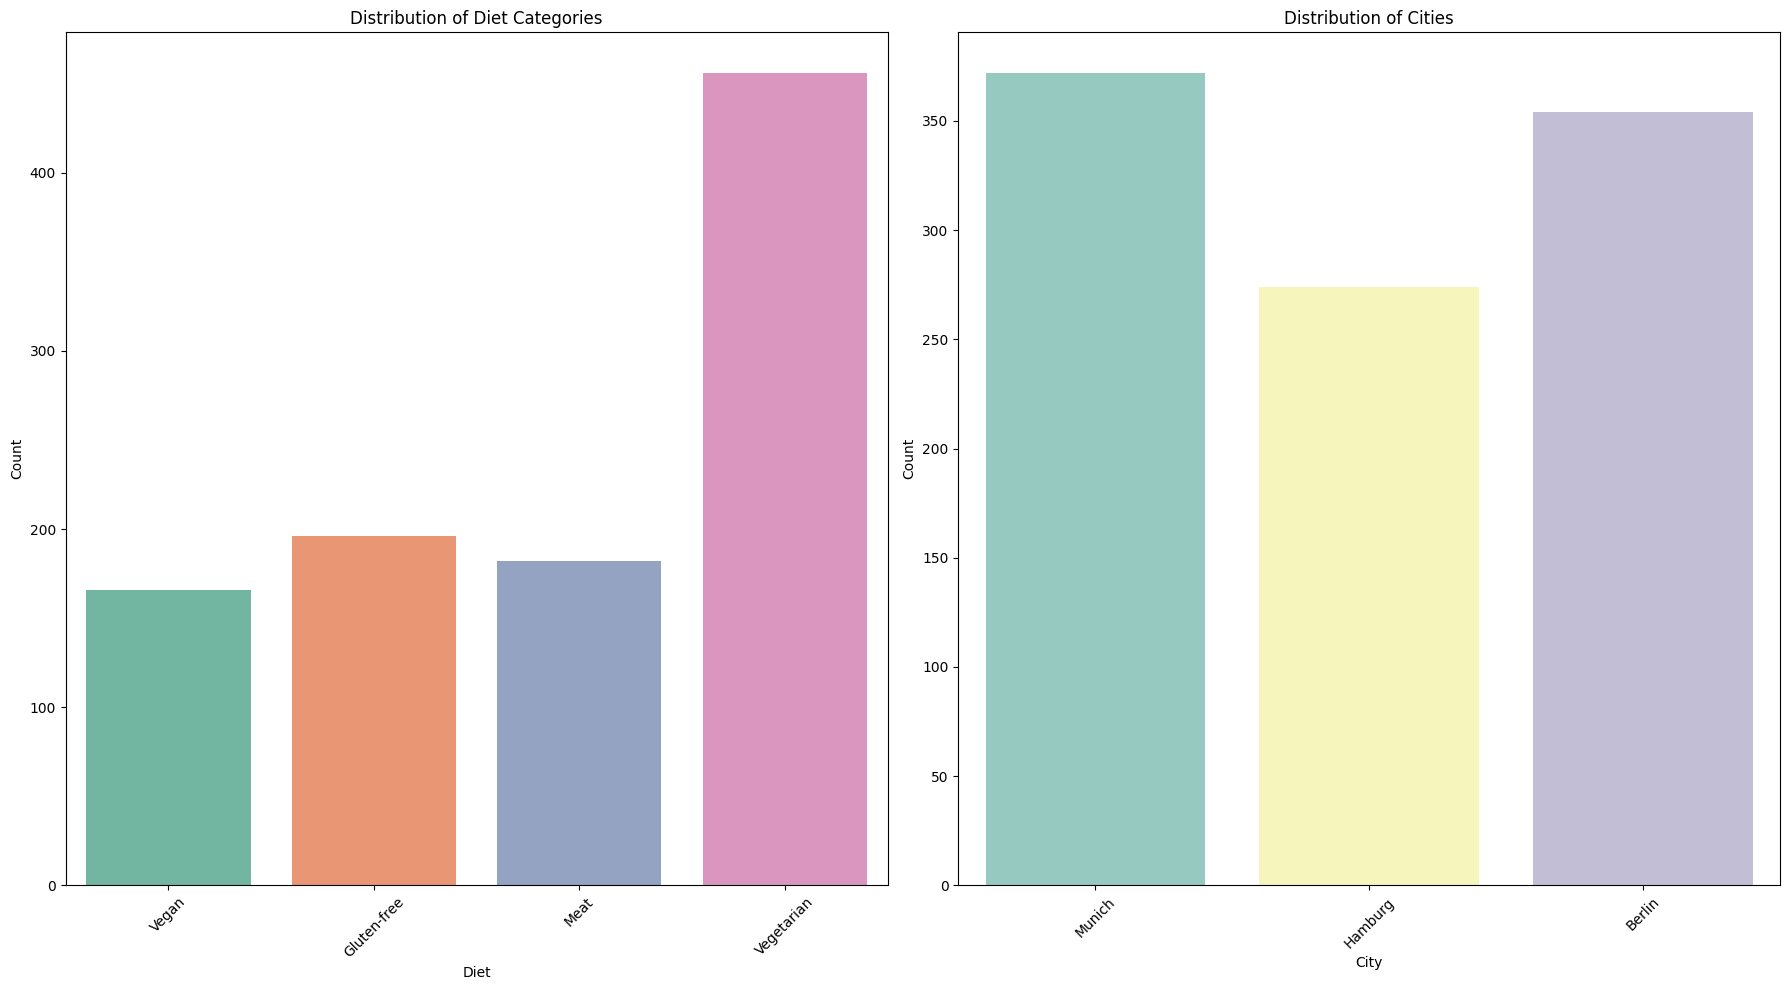

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

sns.countplot(data=combined_data, x='diet', hue='diet', palette='Set2', ax=axes[0], legend=False)
axes[0].set_title('Distribution of Diet Categories')
axes[0].set_xlabel('Diet')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

sns.countplot(data=combined_data, x='city', hue='city', palette='Set3', ax=axes[1], legend=False)
axes[1].set_title('Distribution of Cities')
axes[1].set_xlabel('City')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()

plt.show()

#### Distibution of dish categories

The largest category is Cuisine Type, which accounts for 21.0% of the data, indicating that dishes representing diverse world cuisines, such as Italian, Mexican, and Chinese, make up a significant portion. The other categories are well balanced ranging between 8.3% to 11.1%. The significant difference between cuisine category and others can be reduced by potentially improving the sales of the other dish categories besides the cuisine category.

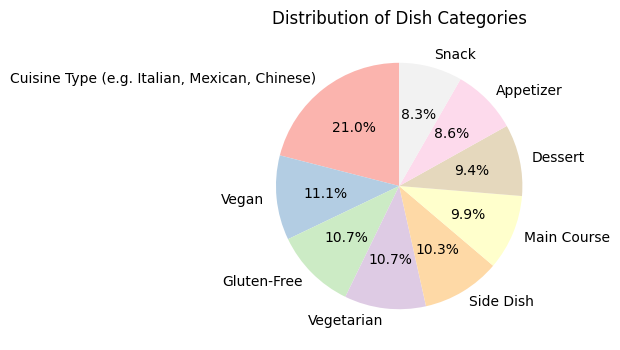

In [48]:
category_counts = combined_data['category'].value_counts()    

plt.figure(figsize=(4, 4))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Pastel1.colors)
plt.title('Distribution of Dish Categories')
plt.show()

In [49]:
dates_parsed = pd.to_datetime(combined_data['date'], format='%Y-%m-%dT%H:%M:%SZ')

#### Distribution of orders by day

The chart shows a relatively even distribution of orders across the week, with Tuesday and Thursday being the busiest days, followed by Wednesday, Friday. Sunday and Monday have the lowest shares of orders.Since, BellaBona delivers lunch to office workers, the trend justifies as the weekends have the lowest number of orders on average. 

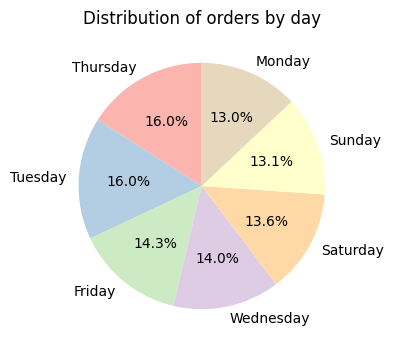

In [50]:
dates = pd.DataFrame(dates_parsed.dt.day_name())

day_count = dates['date'].value_counts()    

plt.figure(figsize=(4, 4))
plt.pie(day_count, labels=day_count.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Pastel1.colors)
plt.title('Distribution of orders by day')
plt.show()

In [51]:
date = pd.DataFrame(dates_parsed.dt.date)
daily_revenue = combined_data.groupby('date')['price'].sum().reset_index()


In [52]:
hour = pd.DataFrame(dates_parsed.dt.hour).sort_index()

#### Number of Orders by Time of Day

We classify the time of the day as 4 parts. The business's peak operational hours are likely during the overnight period, with lower but still significant demand in the afternoon and evening. The morning has the lowest order volume.

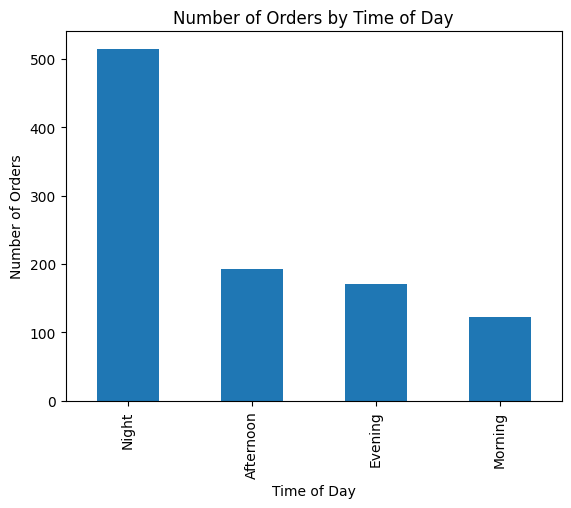

In [53]:
def categorize_time(hour):
    if 5 <= hour < 8:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'
    
hour['time_category'] = hour['date'].apply(categorize_time)

category_counts = hour['time_category'].value_counts()

category_counts.plot(kind='bar')
plt.xlabel('Time of Day')
plt.ylabel('Number of Orders')
plt.title('Number of Orders by Time of Day')
plt.show()

In [54]:
combined_data.head()


,date,diet,city,id,name,category,price
0,2024-05-01T00:04:34Z,Vegan,Munich,cc6adc74-fe56-840c-9cd0-015948f2e774,Baked Ziti,"Cuisine Type (e.g. Italian, Mexican, Chinese)",4.23
1,2024-05-01T21:45:03Z,Gluten-free,Hamburg,b5843967-cf48-5bf0-a5c9-170a1933e7a8,Fish Tacos,Main Course,11.71
2,2024-05-01T22:13:14Z,Meat,Hamburg,0eca4f84-43ab-656e-d14b-1fbd6acc525f,Grilled Salmon,Gluten-Free,11.51
3,2024-05-02T01:04:56Z,Vegan,Munich,eb62fde4-4f43-c7f6-d323-0d0e4131ac17,Shrimp Pad Thai,Vegetarian,7.30
4,2024-05-02T05:45:23Z,Vegetarian,Munich,493fa57d-3850-8773-442c-2b7afad83933,Caesar Salad,Side Dish,7.61


In [55]:
order_count = combined_data['name'].value_counts()
dish_prices = combined_data.groupby('name')['price'].mean()
dish_count_price = pd.DataFrame({
    'Order Count': order_count,
    'Price': dish_prices
})

dish_count_price = dish_count_price.sort_values(by='Order Count', ascending=False)
print(dish_count_price)

                      Order Count  Price
name                                    
Baked Ziti                    112   4.23
Chicken Tikka Masala          111   9.28
Shrimp Pad Thai               107   7.30
Grilled Salmon                107  11.51
Caesar Salad                  103   7.61
Fish Tacos                     99  11.71
Quiche Lorraine                98   9.53
Beef Stroganoff                94   5.60
Stuffed Bell Peppers           86   8.84
Spaghetti Carbonara            83   4.74


In [56]:
order_count_per_user_dish = combined_data.groupby(['id', 'name']).size().reset_index(name='Order Count')
most_ordered_dish_per_user = order_count_per_user_dish.loc[order_count_per_user_dish.groupby('id')['Order Count'].idxmax()]
print(most_ordered_dish_per_user[['id', 'name', 'Order Count']])

                                     id                  name  Order Count
0  0eca4f84-43ab-656e-d14b-1fbd6acc525f        Grilled Salmon          107
1  493fa57d-3850-8773-442c-2b7afad83933          Caesar Salad          103
2  5d0378fb-45ae-f69a-0c59-80668c414007       Quiche Lorraine           98
3  b5843967-cf48-5bf0-a5c9-170a1933e7a8            Fish Tacos           99
4  bae94eab-79e9-7e69-0699-f7b7263ff8b0       Beef Stroganoff           94
5  cc6adc74-fe56-840c-9cd0-015948f2e774            Baked Ziti          112
6  e284b559-6f65-1288-48f5-6353141553ee  Chicken Tikka Masala          111
7  e5c05c25-c9b9-301d-f09b-e9c589403728  Stuffed Bell Peppers           86
8  eb62fde4-4f43-c7f6-d323-0d0e4131ac17       Shrimp Pad Thai          107
9  fda8cf0b-a9ae-e2d8-ea5d-e421b37e1bc1   Spaghetti Carbonara           83


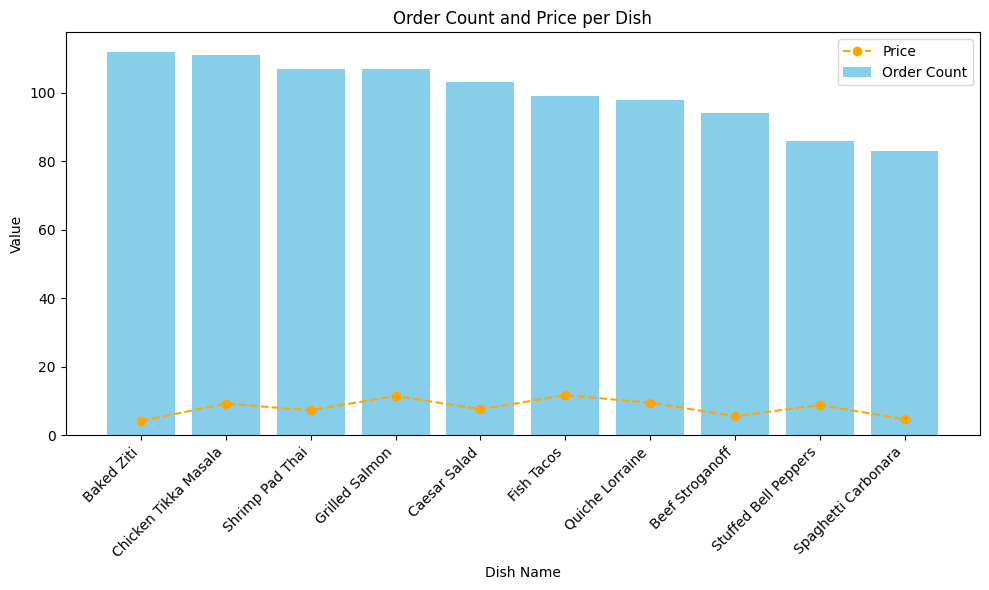

In [57]:
plt.figure(figsize=(10, 6))
plt.bar(dish_count_price.index, dish_count_price['Order Count'], color='skyblue', label='Order Count')
plt.plot(dish_count_price.index, dish_count_price['Price'], color='orange', marker='o', label='Price', linestyle='--')
plt.title('Order Count and Price per Dish')
plt.xlabel('Dish Name')
plt.ylabel('Value')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [58]:
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

combined_data['date'] = pd.to_datetime(combined_data['date'])
combined_data['day_of_week'] = combined_data['date'].dt.day_name()
trending_dishes = combined_data.groupby(['day_of_week', 'name']).size().reset_index(name='order_count')
trending_dishes_per_day = trending_dishes.loc[trending_dishes.groupby('day_of_week')['order_count'].idxmax()]
trending_dishes_per_day['day_of_week'] = pd.Categorical(trending_dishes_per_day['day_of_week'], categories=ordered_days, ordered=True)
trending_dishes_per_day = trending_dishes_per_day.sort_values('day_of_week')

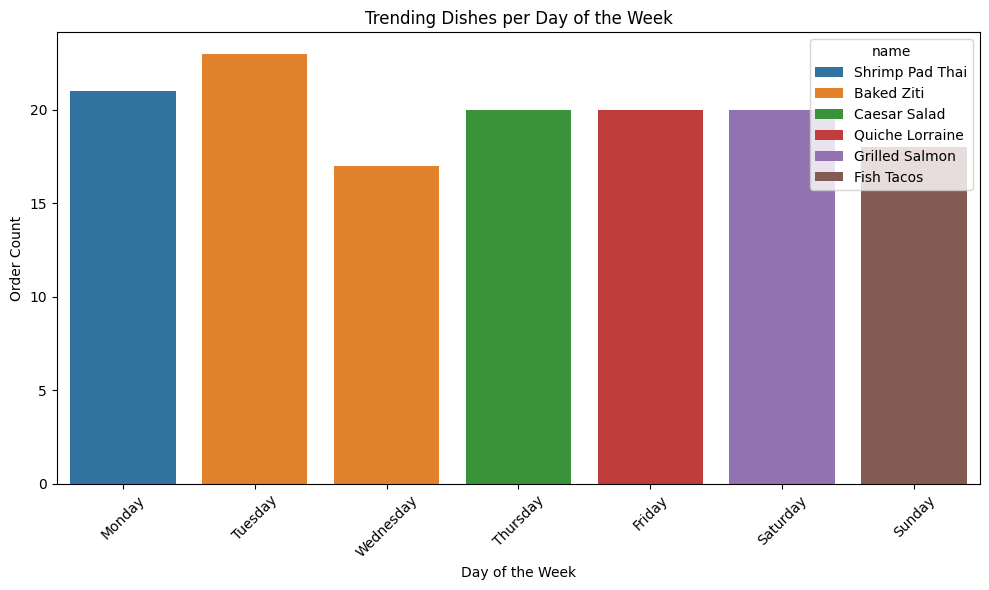

In [59]:
plt.figure(figsize=(10, 6))
sns.barplot(data=trending_dishes_per_day, x='day_of_week', y='order_count', hue='name', dodge=False)
plt.xlabel('Day of the Week')
plt.ylabel('Order Count')
plt.title('Trending Dishes per Day of the Week')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [60]:
combined_data['date'] = pd.to_datetime(combined_data['date']).dt.date

daily_revenue = combined_data.groupby('date')['price'].sum()


In [61]:
combined_data['date'] = pd.to_datetime(combined_data['date'])

combined_data['day_of_week'] = combined_data['date'].dt.day_name()

weekly_revenue = combined_data.groupby('day_of_week')['price'].sum()

weekly_revenue = weekly_revenue[ordered_days]

In [62]:
combined_data['date'] = pd.to_datetime(combined_data['date'])

combined_data['month_year'] = combined_data['date'].dt.to_period('M')

monthly_revenue = combined_data.groupby('month_year')['price'].sum()


#### Revenue visualizations

The visualizations provide insights into the business's revenue trends across daily, weekly, and monthly periods. The daily revenue fluctuates significantly, with recurring patterns of higher revenue towards the end of each month. The bar chart reveals that Monday has the highest average revenue, followed by Tuesday and Wednesday, while weekends have the lowest. Monthly revenue follows a saw-tooth pattern, with June showing the highest and October the lowest. 

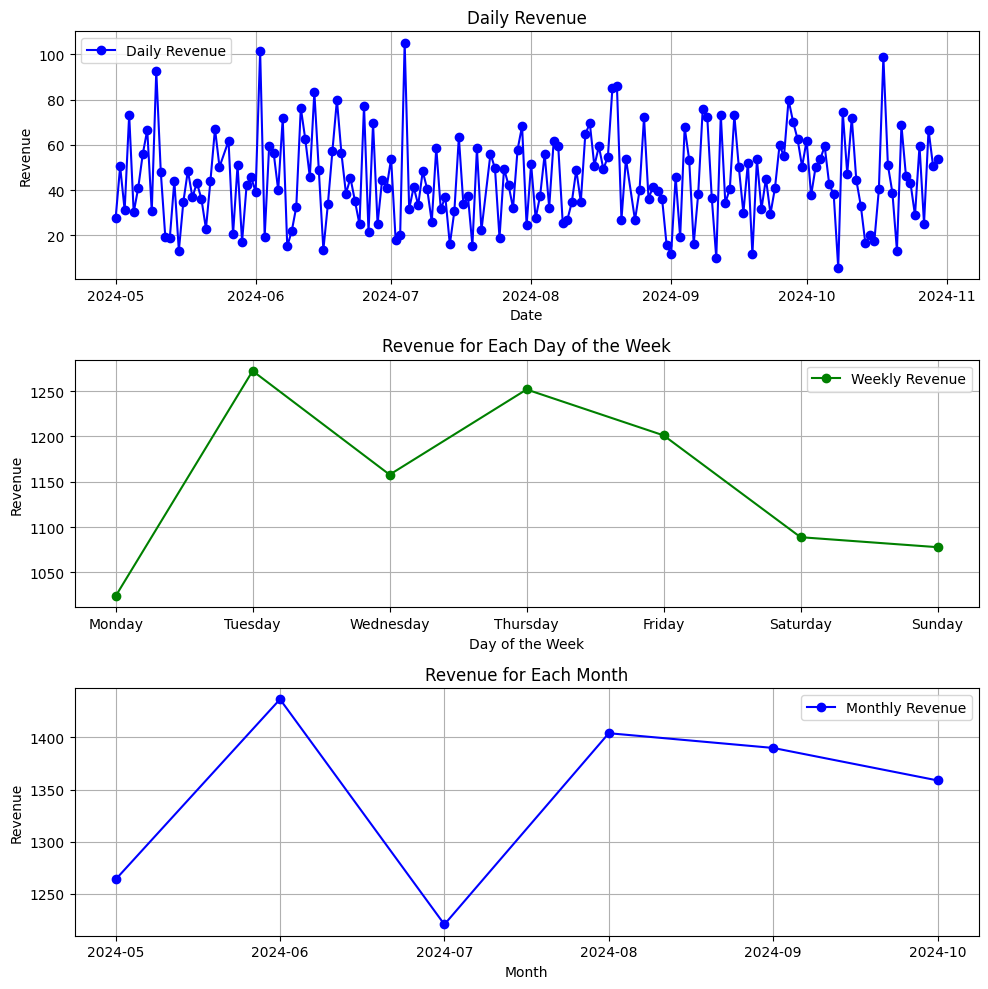

In [63]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10))

axs[0].plot(daily_revenue.index, daily_revenue.values, marker='o', linestyle='-', color='b', label='Daily Revenue')
axs[0].set_title('Daily Revenue')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Revenue')
axs[0].grid(True)
axs[0].legend()

axs[1].plot(weekly_revenue.index, weekly_revenue.values, marker='o', linestyle='-', color='g', label='Weekly Revenue')
axs[1].set_title('Revenue for Each Day of the Week')
axs[1].set_xlabel('Day of the Week')
axs[1].set_ylabel('Revenue')
axs[1].grid(True)
axs[1].legend()


axs[2].plot(monthly_revenue.index.astype(str), monthly_revenue.values, marker='o', linestyle='-', color='b', label='Monthly Revenue')
axs[2].set_title('Revenue for Each Month')
axs[2].set_xlabel('Month')
axs[2].set_ylabel('Revenue')
axs[2].grid(True)
axs[2].legend()

plt.tight_layout()
plt.show()

In [64]:
total_revenue.head()

,month_number,month_name,year,total_revenue
0,05,May,2024,1263.78
1,06,June,2024,1436.56
2,07,July,2024,1220.65
3,08,August,2024,1404.01
4,09,September,2024,1389.89


In [65]:
df = pd.DataFrame(total_revenue)

#### Revenue Forecasting

The chart, featuring the Combined Forecast (purple line), offers a more balanced and accurate representation of future revenue compared to the individual ARIMA (orange line) and Linear Regression (green line) models. The Combined Forecast blends the strengths of both models, capturing short-term volatility while accounting for longer-term trends, providing a more reliable projection that aligns closely with historical revenue patterns. It strikes a middle ground between the ARIMA model’s peaks and valleys and the smoother trend of Linear Regression.

##### ARIMA Hyperparameter Grid Search

We performw a grid search to identify the best hyperparameters for an ARIMA model using AIC (Akaike Information Criterion) as the performance metric.

1. **Parameter Ranges:**
   - `p_values`: Range for the AR (AutoRegressive) order.
   - `d_values`: Range for the differencing order.
   - `q_values`: Range for the MA (Moving Average) order.

2. **Grid Search Logic:**
   - It loops through all combinations of `(p, d, q)` and fits an ARIMA model for each combination.
   - The AIC score is calculated for each model. If the AIC score is better than the previous one, the parameters are updated.

3. **Exception Handling:**
   - If a model fails to fit, it continues to the next combination without interrupting the loop.

4. **Result:**
   - The best combination of parameters `(p, d, q)` with the lowest AIC score is printed.

In [66]:
p_values = range(0, 3)  
d_values = range(0, 2) 
q_values = range(0, 3)  

best_score, best_params = float("inf"), None

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(df['total_revenue'], order=(p, d, q))
                model_fit = model.fit()
                
                aic = model_fit.aic
                if aic < best_score:
                    best_score, best_params = aic, (p, d, q)
                    
            except:
                continue  

print(f'Best ARIMA parameters: {best_params} with AIC: {best_score}')

Best ARIMA parameters: (1, 1, 0) with AIC: 64.02093623607112


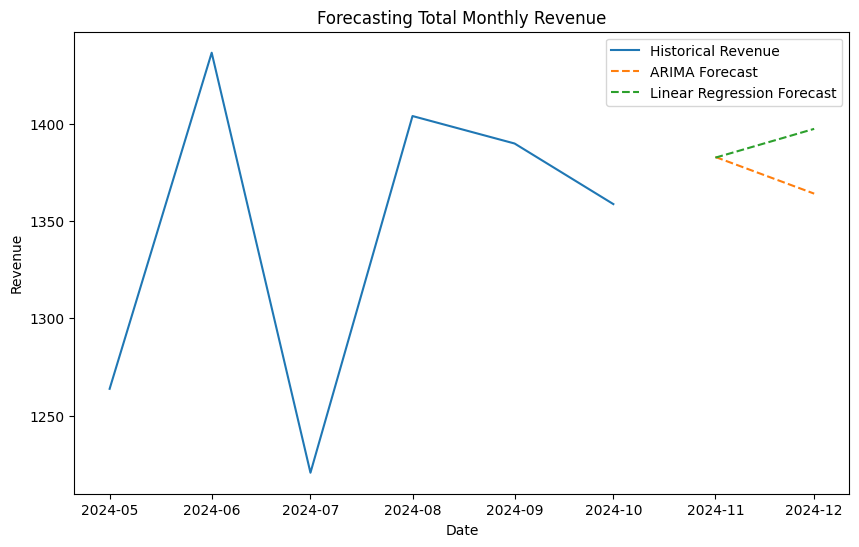

ARIMA Forecast for the next 2 months: 2024-11-01    1382.970715
2024-12-01    1364.122319
Freq: MS, Name: predicted_mean, dtype: float64
Linear Regression Forecast for the next 2 months: [1382.61571429 1397.42      ]


In [67]:
df['date'] = pd.to_datetime(df['month_name'] + ' ' + df['year'].astype(str), format='%B %Y')
df.set_index('date', inplace=True)
df = df.asfreq('MS')  

model_arima = ARIMA(df['total_revenue'], order=(1,1,0))
model_arima_fit = model_arima.fit()

forecast_arima = model_arima_fit.forecast(steps=2)

df['month_number'] = np.arange(1, len(df) + 1)  # Numeric month order
X = df['month_number'].values.reshape(-1, 1)
y = df['total_revenue'].values

lr_model = LinearRegression()
lr_model.fit(X, y)
future_months = np.array([6, 7]).reshape(-1, 1)  # Next two months
forecast_lr = lr_model.predict(future_months)

plt.figure(figsize=(10,6))
plt.plot(df.index, df['total_revenue'], label='Historical Revenue')
plt.plot(pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods=2, freq='MS'), forecast_arima, label='ARIMA Forecast', linestyle='--')
plt.plot(pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods=2, freq='MS'), forecast_lr, label='Linear Regression Forecast', linestyle='--')
plt.title('Forecasting Total Monthly Revenue')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.show()

print("ARIMA Forecast for the next 2 months:", forecast_arima)
print("Linear Regression Forecast for the next 2 months:", forecast_lr)


In [68]:
result = adfuller(df['total_revenue'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -4.575691971169582
p-value: 0.00014317203541394866


#### SARIMA Hyperparameter Grid Search

WE perform a grid search to find the best hyperparameters for a SARIMA model using the AIC (Akaike Information Criterion).

1. **Parameter Ranges:**
   - `p_values`, `d_values`, `q_values`: Non-seasonal AR, differencing, and MA orders.
   - `P_values`, `D_values`, `Q_values`: Seasonal AR, differencing, and MA orders.
   - `s`: The length of the seasonal cycle (e.g., 12 for monthly data with yearly seasonality).

2. **SARIMA AIC Calculation:**
   - The `sarima_aic()` function fits a SARIMAX model and calculates the AIC score for each parameter combination.

3. **Grid Search Logic:**
   - It loops through all combinations of `(p, d, q, P, D, Q)` using `itertools.product()`.
   - For each combination, the model is fitted, and the AIC score is calculated. The combination with the lowest AIC is selected.

4. **Exception Handling:**
   - If a model fails to fit (due to bad parameters), it skips that combination.

5. **Final Model:**
   - After finding the best parameters, a final SARIMA model is fitted with those parameters, and the model's summary is printed.

In [69]:
p_values = range(0, 3)  
d_values = range(0, 2) 
q_values = range(0, 3) 

P_values = range(0, 3)  
D_values = range(0, 2)  
Q_values = range(0, 3)  
s = 6  

def sarima_aic(p, d, q, P, D, Q, s):
    model = SARIMAX(df['total_revenue'], 
                    order=(p, d, q), 
                    seasonal_order=(P, D, Q, s), 
                    enforce_stationarity=False, 
                    enforce_invertibility=False)
    result = model.fit(disp=False)
    return result.aic

best_aic = np.inf
best_params = None

for param in itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values):
    p, d, q, P, D, Q = param
    try:
        aic = sarima_aic(p, d, q, P, D, Q, s)
        if aic < best_aic:
            best_aic = aic
            best_params = param
    except:
        continue

print(f"Best SARIMA Parameters: p={best_params[0]}, d={best_params[1]}, q={best_params[2]}, "
      f"P={best_params[3]}, D={best_params[4]}, Q={best_params[5]}")

best_model = SARIMAX(df['total_revenue'], 
                     order=(best_params[0], best_params[1], best_params[2]),
                     seasonal_order=(best_params[3], best_params[4], best_params[5], s),
                     enforce_stationarity=False,
                     enforce_invertibility=False)
best_result = best_model.fit(disp=False)
print(best_result.summary())

Best SARIMA Parameters: p=0, d=1, q=2, P=0, D=0, Q=0
                               SARIMAX Results                                
Dep. Variable:          total_revenue   No. Observations:                    6
Model:               SARIMAX(0, 1, 2)   Log Likelihood                   8.034
Date:                Thu, 14 Nov 2024   AIC                            -10.068
Time:                        16:24:29   BIC                            -13.989
Sample:                    05-01-2024   HQIC                           -18.267
                         - 10-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.7442   2.74e-06  -6.37e+05      0.000      -1.744      -1.744
ma.L2         -0.7938      0.000  -4108.487      0.000      -0.794      -0.793

Predicted Mean Revenue for the next 2 months:
2024-11-01    1358.740704
2024-12-01    1358.740838
Freq: MS, Name: predicted_mean, dtype: float64


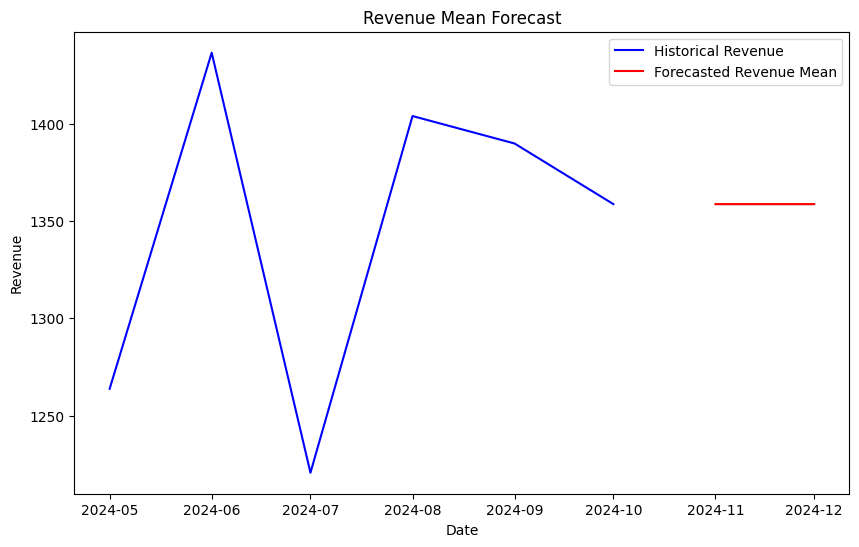

In [70]:
forecast_steps = 2
forecast = best_result.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

print("Predicted Mean Revenue for the next 2 months:")
print(forecast_mean)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['total_revenue'], label='Historical Revenue', color='blue')
plt.plot(forecast_mean.index, forecast_mean, label='Forecasted Revenue Mean', color='red')
plt.fill_between(forecast_mean.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='gray', alpha=0.3)
plt.title('Revenue Mean Forecast')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.show()


#### Future Works

1. **Primary Model Selection:** 

Adopting the Combined Forecast as the main model for revenue projection. Its balance between volatility and trend makes it the most accurate representation of future revenue.

2. **Advanced Forecasting Techniques:**

Considering exploring more advanced forecasting methods like ensemble models. These can capture more complex patterns in the data, further enhancing predictive accuracy.

## **Part 3: Business Insights**

1. **Key Insights**

   a. The number of orders on **{Saturday,Sunday,Monday}** are significantly lesser than the other days. The daily revenue fluctuates significantly, with recurring patterns of higher revenue towards the end of each month.
   
   b. Despite some variation in the monthly revenue, the general trend does not show any significant upward or downward movement.

   c. Considering the orders distruibution based upon the time of the day, there are significantly greater number of orders during nighttime. There is no much differences in the orders distruibution based upon cities.  

   d. The dishes, with price, like Baked Ziti (4.23) and Spaghetti Carbonara (4.74), have the highest and lowest order counts respectively, indicating that affordability might not contribute to higher popularity.


2. **Recommendations for improving monthly user activation**

    a. Monitoring User Activities - Analyze how a user places their order and their engagement patterns. For example, user *{0eca4f84-43ab-656e-d14b-1fbd6acc525f}* ordered Grilled Salmon for 107 times.Offering personalized discounts based on their order history and preferences can promote users to order again.

    b. Push Notifications - Sending a reminder offering a special discount for their next order or highlighting new menu items that align with their preferences can also increase order rate.

    c. User registration and their order date - Tracking the time between user registration and their first order, as well as the frequency of orders after registration can tells us about the engagements. It can also helps us in finding if the application is simple for the user to use. Offers on the first time order can also increase user activities.

    d. Feedback - By regularly checking in with users to understand their needs and desires, we can ensure that the order process is consistently meeting their expectations. 


3. **Additional data points**

    a. Seasonal Trends like holidays, special events 

    b. Real-Time Activity Data
    
    c. Cohort Details like when they first signed up or made their first purchase 